### This notebook aims to numerically mimic the QPT process for a few-qubit-quantum-gate based on the qiskit simulator, where the realistic noise and error are taken into account.

Notes:  1.QPT for the one-qubit channel costs a few seconds on a laptop; less than 2 minutes for 2-q channel; more then ten hours for 3-q channel.
2. the initial states and rotations setup in QTP.py should be consistant with experiments (numerics ).


In [5]:
#====================some useful functions==========================

from QPT import QPT
from QPT import *
from numExp_qiskit import NumExp
from joblib import Parallel, delayed
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import itertools, random
from qutip import Qobj
from qutip.random_objects import rand_super_bcsz, rand_kraus_map, rand_unitary
from qiskit.quantum_info import random_unitary, Operator, average_gate_fidelity, Kraus, Chi, Choi
from scipy.linalg import sqrtm
from functions import *

def generate_valid_cptp_kraus_operators(n_qubits, num_kraus):
    """
    Generate a set of Kraus operators that satisfy the CPTP condition, ensuring ∑ K_i† K_i = I.

    Parameters:
    - n_qubits (int): Number of qubits
    - num_kraus (int): Number of Kraus operators to generate

    Returns:
    - list of numpy.ndarray: List of Kraus operators
    """
    # Define Pauli matrices for single qubits
    pauli = [qeye(2), sigmax(), sigmay(), sigmaz()]
    
    # Generate the tensor product of Pauli matrices for all possible combinations of qubits
    Elist = [tensor(*op).full() for op in itertools.product(pauli, repeat=n_qubits)]
    
    # Create Kraus operators by summing weighted Pauli matrices
    kraus_ops = [
        np.sum([(np.random.randn() + 1j * np.random.randn()) * E for E in Elist], axis=0)
        for _ in range(num_kraus)
    ]
    
    # Ensure the CPTP condition: ∑ K_i† K_i = I
    sum_kdag_k = sum(K.conj().T @ K for K in kraus_ops)
    sqrt_inv = np.linalg.inv(sqrtm(sum_kdag_k))
    
    # Normalize the Kraus operators to satisfy CPTP
    kraus_ops = [K @ sqrt_inv for K in kraus_ops]
    
    # Verify the CPTP condition again
    sum_kraus = sum(K.conj().T @ K for K in kraus_ops)
    
    if not np.allclose(sum_kraus, np.eye(2**n_qubits), rtol=1e-5):
        raise ValueError("The generated Kraus operators do not satisfy the CPTP condition!")
    
    # If only one Kraus operator is requested, generate a random unitary operator
    if num_kraus == 1:
        kraus_ops = [rand_unitary(2 ** n_qubits).full()]
    
    return kraus_ops

def get_chiF(chi1, chi2):
    """Calculate the fidelity between two quantum processes represented by χ matrices."""
    sqrt_chi1 = sqrtm(chi1)
    return np.real(np.trace(sqrtm(sqrt_chi1 @ chi2 @ sqrt_chi1))**2)


def get_exp_plot(measure_data,N):
  
    '''
    Visualizing the measurement data for a N-qubit gate (only for 1-q gate)
    '''

    if N<2:
        rotation = ["I", "ry(90)", 'rx(90)']
        initial_state =['|0>','|+>','|->','|1>']
        observables =['|0><0|','|1><1|']
        cir_lab = list(product(initial_state,rotation))
        
        z = measure_data  
        th = 0
        ylabel = []
        plt.figure()
        fig, ax = plt.subplots(figsize=(4,8))
        ax.imshow(z)
        ax.set_xticks(np.arange(len(observables)), labels=observables)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        for j in range(len(z)):
            for k in range(len(z[0])):
                text = ax.text(k,th, round(z[th,k], 3), ha="center", va="center", color="w")
            th+=1
            ylabel.append(cir_lab[j][0]+','+cir_lab[j][1])
        ax.set_yticks(np.arange(len(ylabel)), labels=ylabel)
        plt.show()
    else:
        print('It is only for N=1')
 



In [2]:
np.random.normal(loc=1, scale=0.2, size=1)[0]

1.1988674250513789

### The measurement data for a complete QPT of N-qubit quantum process

Example 1: the identity channel

p_reset: 0.0 p_meas: 0.0 p_unitary: 0.0
(12, 2)


<Figure size 640x480 with 0 Axes>

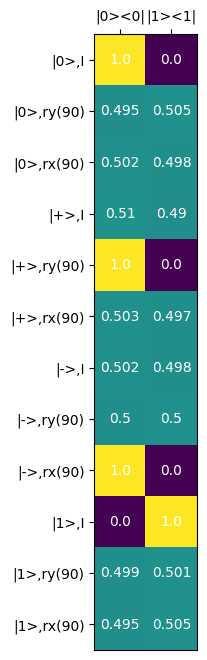

In [6]:
"""
Parameters:
- N (int): Number of qubits
- p_reset (float): State preparation (SP) error
- p_meas (float): Measurement (M) error
- random_channel (list, optional): Random quantum channel
- num_kraus (int): the number of Kraus operator
"""

# Obtain the measurement data for a randomly sampled quantum channel
N, p_tot,num_kraus = 1, 0.00,1 
rdw = np.random.random(1)[0] # the weight coefficient
p_reset = p_tot * rdw
p_meas = p_tot* (1 - rdw)
p_unitay = p_tot
print('p_reset:', p_reset, 'p_meas:', p_meas,'p_unitary:', p_unitay)
random_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)

# =========the numeric simulator===========#
Uid = np.identity(2 ** N)
# p_reset, p_meas, = 0.0,0
qiskit_sim = NumExp()
# An example: identity channel for illustration
measure_data = qiskit_sim.get_measurement(N, p_reset, p_meas,p_unitay,[Uid] )
print(np.shape(measure_data))
get_exp_plot(measure_data,N)

### The standard QPT and EM-QPT

In [4]:
from functions import get_idea_chi_matrix
p_tot,num_kraus = 0.01,1# 
rdw = np.random.random(1)[0] # the weight coefficient for SPAM error
p_reset = p_tot * rdw
p_meas = p_tot* (1 - rdw)
p_unitay = p_tot
print('p_reset:', p_reset, 'p_meas:', p_meas,'p_unitary:', p_unitay)
Ucz = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])

random_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)
print(random_channel)

# Define the Hilbert space dimension
ddim = [[2] * N, [2] * N]

# (1) the QPT experiments of identity
measure_data_id = qiskit_sim.get_measurement(N, p_reset, p_meas, p_tot,[np.identity(2 ** N)])

# (2) the identity QPT
qiskit_sim = NumExp()
qptid = QPT(N, measure_data_id, random_channel)
chi_id_pred = qptid.get_chi_LS_X(qptid.rho_in_idea, qptid.observables)


# (3) the standard QPT 
measure_data = qiskit_sim.get_measurement(N, p_reset, p_meas,p_tot, random_channel)
qpt0 = QPT(N, measure_data, random_channel)
chi_pred = qpt0.get_chi_LS_X(qpt0.rho_in_idea, qpt0.observables) 
chi_idea = get_idea_chi_matrix(random_channel, N)

# (4) the error-mitigated  QPT 
proj_noisy = qpt0.get_noisy_proj_1(chi_id_pred)
rho_in_noisy = qpt0.get_noisy_state(chi_id_pred)

#rho_out_idea = [Qobj(np.sum([K @ rho.full() @ K.conj().T for K in random_channel], axis=0),dims=ddim,) for rho in qpt0.rho_in_idea]

chi_EM_a = qpt0.get_chi_LS_X(rho_in_noisy, qpt0.observables)
chi_EM_b = qpt0.get_chi_LS_X(qpt0.rho_in_idea, proj_noisy)
chi_EM_c = qpt0.get_chi_LS_X(rho_in_noisy, proj_noisy)

FF_noEM = get_chiF(chi_pred, chi_idea)
print(f"Fidelity (no EM): {FF_noEM}")

FF_EM_a =  get_chiF(chi_EM_a, chi_idea)
print(f"Fidelity (with EMa): {FF_EM_a}")

FF_EM_b = get_chiF(chi_EM_b, chi_idea)
print(f"Fidelity (with EMb): {FF_EM_b}")

FF_EM_c = get_chiF(chi_EM_c, chi_idea)
print(f"Fidelity (with EMc): {FF_EM_c}")


p_reset: 0.005640750676198766 p_meas: 0.004359249323801234 p_unitary: 0.01
[array([[ 0.641622  +0.3122065j ,  0.14132096-0.039941j  ,
        -0.11155734+0.23253655j,  0.05107964+0.63257727j],
       [ 0.13930022+0.03308181j,  0.73803618-0.20190987j,
        -0.24653984+0.30587826j, -0.03644212-0.48822598j],
       [ 0.16819937+0.19437671j,  0.390766  +0.00686424j,
         0.71391351-0.51888072j, -0.03333224-0.03406973j],
       [-0.1180953 +0.62476357j, -0.23406745-0.43062204j,
         0.01236055+0.00870811j,  0.55800022-0.20954284j]])]
Fidelity (no EM): 0.9822239079281972
Fidelity (with EMa): 0.9953070774441741
Fidelity (with EMb): 0.9951865066039342
Fidelity (with EMc): 0.9998869441434599


### Plot the Chi matrix and revised probes

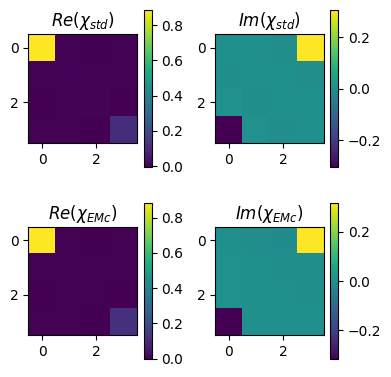

In [5]:
# the \chi matrix
zlist =[np.real(chi_pred),np.imag(chi_pred),np.real(chi_EM_c),np.imag(chi_EM_c)]
titlist = [r'$Re(\chi_{std})$',r'$Im(\chi_{std})$',r'$Re(\chi_{EMc})$',r'$Im(\chi_{EMc})$']
# print(np.abs(chi_pred-chi_EM_c))
plt.figure(figsize=(4,4))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(zlist[i])
    plt.colorbar()
    plt.title(titlist[i])
plt.tight_layout()



Text(0, 0.5, '$F(\\rho_{i},\\bar{\\rho_i})$')

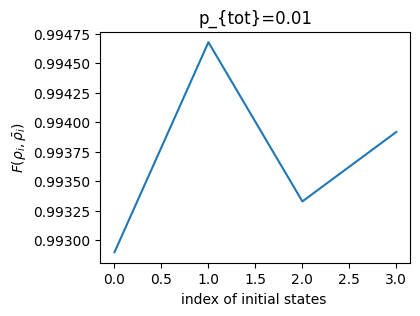

In [6]:
# the fidelty between the ideal and revised input states for a given error rate 
Flist = [get_chiF(rho_in_noisy[i].full(),qpt0.rho_in_idea[i].full()) for i in range(len(rho_in_noisy))]
plt.figure(figsize=(4,3))
plt.plot(Flist)
plt.title('p_{tot}='+str(p_tot))
plt.xlabel('index of initial states ')
plt.ylabel(r'$F(\rho_{i},\bar{\rho_i})$')

In [10]:
# ================================================================================
# ================ computing the figure1 with parallel setup=======================
# ================================================================================

def get_result(N,p_tot,p_unitary,num_kraus):
    num_kraus =  np.random.randint(0,2**(2*N)+1)+1#1#num_kraus#
    rdw =  np.random.random(1)[0] # the weight coefficient for SPAM error
    p_reset = p_tot * rdw
    p_meas = p_tot* (1 - rdw)
    random_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)
    qiskit_sim = NumExp()
    # (1) the QPT experiments of identity
    measure_data_id = qiskit_sim.get_measurement(N, p_reset, p_meas,p_unitary, [np.identity(2 ** N)])
    # (2) the identity QPT
    qptid = QPT(N, measure_data_id, random_channel)
    chi_id_pred = qptid.get_chi_LS_X(qptid.rho_in_idea, qptid.observables)
    # (3) the standard QPT 
    measure_data = qiskit_sim.get_measurement(N, p_reset, p_meas,p_unitary, random_channel)
    qpt0 = QPT(N, measure_data, random_channel)
    chi_pred = qpt0.get_chi_LS_X(qpt0.rho_in_idea, qpt0.observables) 
    chi_idea = get_idea_chi_matrix(random_channel, N)
    # (4) the error-mitigated  QPT 
    proj_noisy = qpt0.get_noisy_proj_1(chi_id_pred)
    rho_in_noisy = qpt0.get_noisy_state(chi_id_pred)
    #rho_out_idea = [Qobj(np.sum([K @ rho.full() @ K.conj().T for K in random_channel], axis=0),dims=ddim,) for rho in qpt0.rho_in_idea]
    chi_EM_a =  chi_pred #qpt0.get_chi_LS_X(rho_in_noisy, qpt0.observables)
    chi_EM_b =  chi_pred#qpt0.get_chi_LS_X(qpt0.rho_in_idea, proj_noisy)
    chi_EM_c =  qpt0.get_chi_LS_X(rho_in_noisy, proj_noisy)
    return chi_id_pred,chi_idea,chi_pred,chi_EM_a,chi_EM_b,chi_EM_c

def get_resultn(N,p_inco,p_co,num_kraus):
    # rdw =  1#np.random.random(1)[0] 
    # p_inco,p_unitary =p_tot * rdw,p_tot* (1 - rdw)
    FF_noEMlist,FF_EM_alist,FF_EM_blist,FF_EM_clist =[],[],[],[]
    for i in range(20):
        chi_id_pred,chi_idea,chi_pred,chi_EM_a,chi_EM_b,chi_EM_c = get_result(N,p_inco,p_co,num_kraus)
        FF_noEM = get_chiF(chi_pred, chi_idea);FF_noEMlist.append(FF_noEM)
        FF_EM_a =  get_chiF(chi_EM_a, chi_idea)
        FF_EM_alist.append(FF_EM_a)
        FF_EM_b =  get_chiF(chi_EM_b, chi_idea)
        FF_EM_blist.append(FF_EM_b)
        FF_EM_c = get_chiF(chi_EM_c, chi_idea);FF_EM_clist.append(FF_EM_c)
    return [FF_noEMlist,FF_EM_alist,FF_EM_blist,FF_EM_clist]#

# ================================================================================
# ================ collecting training data for the ML-QPT =======================
# ================================================================================

def get_chi_id(N,p_inco,p_co):
    rdw =  np.random.uniform()#np.random.random(1)[0] # the weight coefficient for SPAM error
    p_reset = p_inco * rdw
    p_meas = p_inco* (1 - rdw)
    qiskit_sim = NumExp()
    # (1) the QPT experiments of identity
    measure_data_id = qiskit_sim.get_measurement(N, p_reset, p_meas,p_co, [np.identity(2 ** N)])
    # (2) the identity QPT
    qptid = QPT(N, measure_data_id, [np.identity(2 ** N)])
    chi_id_pred = qptid.get_chi_LS_X(qptid.rho_in_idea, qptid.observables)
    return  chi_id_pred

def get_chi_idn(N,p_tot,p_co):
    chi_id_pred_list = Parallel(n_jobs=10, verbose=2)(delayed(get_chi_id)(N,p_tot,p_co) for i in range(1000))
    return chi_id_pred_list


# plist = 10**(np.linspace(-2,0,11))[:10]#np.linspace(0.0001 ,0.2,10)
# plist1 = 10**(np.linspace(-2,0,11))[:10]

plist = 10**(np.linspace(-2,0,26)) #np.linspace(0.0001 ,0.2,10)
plist = 10**(np.linspace(-2,0,13))
#num_kraus_list = [1]#np.arange(2**(2*N))

# =============================================================================================
# ===== Notes: collecting training data one-datapoint:18s(N=2),<1s(N=1) =======================
# =============================================================================================

N = 2
num_kraus =1
F_cell = []
F_cell_p = Parallel(n_jobs=10, verbose=5)(delayed(get_resultn)(N,p_co,p_co,num_kraus) for p_co in plist)
#print(np.shape(F_cell_p))
#for p in plist:
# for num_kraus in range(4):
#     num_kraus+=1
#     F_cell_p = Parallel(n_jobs=10, verbose=5)(delayed(get_resultn)(N,p_co,p_co,num_kraus) for p_co in plist)
#     print(np.shape(F_cell_p))
#     np.savez('F_1q_'+str(num_kraus+1)+'kraus_log_2d_selected_cptp.npz',F_cell_p=F_cell_p,plist=plist)
# chi_cell_p = [get_chi_idn(N,p_co,p_co) for p_co in plist[4:]]#get_chi_idn(N,plist[0],0.0)#
# print(np.shape(chi_cell_p))
#F_cell.append(F_cell_p)
#np.savez('./F_cell_'+str(N)+'q'+''+str(num_kraus)+'_kraus.npz',F_cell_p=F_cell_p,plist=plist)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  13 | elapsed: 26.2min remaining: 87.5min
[Parallel(n_jobs=10)]: Done   6 out of  13 | elapsed: 32.3min remaining: 37.7min
[Parallel(n_jobs=10)]: Done   9 out of  13 | elapsed: 32.9min remaining: 14.6min
[Parallel(n_jobs=10)]: Done  13 out of  13 | elapsed: 47.8min finished


In [ ]:
#np.savez('chi_2q_1kraus_log_2d_selected4_8.npz',chi_cell_p=chi_cell_p,plist=plist)
#np.savez('F_1q_1kraus_log_2d_selected.npz',F_cell_p=F_cell_p,plist=plist,plist1=plist1)
#np.savez('F_2q_randkraus_cptp.npz',F_cell_p=F_cell_p,plist=plist)

In [ ]:
#print(hty)

NameError: name 'hty' is not defined

/var/folders/gt/wsynvnn526b468b8m4bq36g00000gn/T/ipykernel_16381/2114497588.py:6: RuntimeWarning: invalid value encountered in log10
  F_cell_p1 =np.log10(1-np.array(F_cell_p))


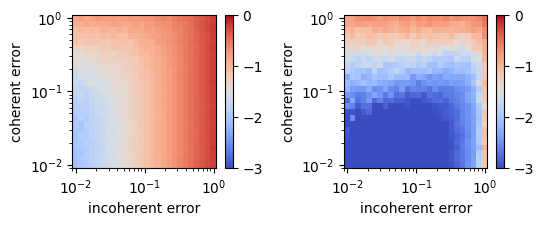

In [ ]:
#np.savez('F_1q_1kraus_log_2d.npz',F_cell_p=F_cell_p,plist=plist,plist1=plist1)
#np.savez('chi_2q_1kraus_log_final.npz',chi_cell_p=chi_cell_p,plist=plist)

plt.figure(figsize=(5.5, 2.2))
lenth = len(plist)*len(plist1)
F_cell_p1 =np.log10(1-np.array(F_cell_p))
F_cell_noEM = np.array([np.nanmean(F_cell_p1[i,0,:]) for i in range(lenth)]).reshape(len(plist),len(plist1))
F_cell_EMc = np.array([np.nanmean(F_cell_p1[i,3,:]) for i in range(lenth)]).reshape(len(plist),len(plist1))
#F_cell_noEM,F_cell_EMc = np.log10(1-F_cell_noEM),np.log10(1-F_cell_EMc)
vi,vx = -3,0
cp = 'coolwarm'#'bwr'
plt.subplot(1,2,1)
plt.pcolor(plist ,plist1,F_cell_noEM,vmin=vi,vmax=vx,cmap=cp)
plt.colorbar()
plt.ylabel('coherent error')
plt.xlabel('incoherent error')
plt.xscale('log')
plt.yscale('log')
plt.subplot(1,2,2)
plt.pcolor(plist ,plist1,F_cell_EMc,vmin=vi,vmax=vx,cmap=cp)
plt.colorbar()
plt.ylabel('coherent error')
plt.xlabel('incoherent error')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout(pad=0.5)

In [ ]:
# np.savez('fig1_2q_1kraus_chi2.npz',chi_cell_p=chi_cell_p,plist=plist)

In [ ]:
# data0 = np.load('fig1_2q_1kraus_chi1.npz')['chi_cell_p']
# data1 = np.load('fig1_2q_1kraus_chi2.npz')['chi_cell_p']

# chi_cell = np.zeros(shape=(10,1000,16,16))+1j*np.zeros(shape=(10,1000,16,16))
# chi_cell[:4,:,:,:]=data0
# chi_cell[4:,:,:,:]=data1
# np.shape(chi_cell)
# #np.savez('fig1_2q_1kraus_chi.npz',chi_cell_p=chi_cell,plist=plist)

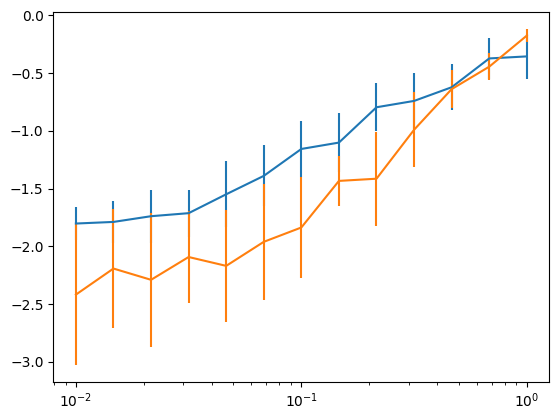

In [11]:
plt.figure()
lenth = len(plist)
F_cell_p = np.array(F_cell_p)
F_cell_p1 = np.array(np.log10(1-F_cell_p) )
F_cell_noEM = np.array([np.average(F_cell_p1[i,0,:]) for i in range(lenth)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
F_cell_noEM_std = np.array([np.std(F_cell_p1[i,0,:]) for i in range(lenth)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))

F_cell_EMc = np.array([np.average(F_cell_p1[i,3,:]) for i in range(lenth)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
F_cell_EMc_std = np.array([np.std(F_cell_p1[i,3,:]) for i in range(lenth)])#.reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))

plt.errorbar(plist,F_cell_noEM,F_cell_noEM_std)
plt.errorbar(plist,F_cell_EMc,F_cell_EMc_std)
plt.xscale('log')

#plt.yscale('log')
#F_cell_noEM,F_cell_EMc = np.log10(1-F_cell_noEM),np.log10(1-F_cell_EMc)
# vi,vx = -3,0
# plt.subplot(1,2,1)
# plt.pcolor(plist ,plist1,F_cell_noEM.T,vmin=vi,vmax=vx)
# plt.colorbar()
# plt.ylabel('coherent error')
# plt.xlabel('incoherent error')
# plt.subplot(1,2,2)
# plt.pcolor(plist ,plist1,F_cell_EMc.T,vmin=vi,vmax=vx)
# plt.colorbar()
# plt.ylabel('coherent error')
# plt.xlabel('incoherent error')

In [ ]:

#np.savez('fig_1q_1kraus_2d.npz',F_cell_p=F_cell_p, plist=plist, plist1=plist1)

In [ ]:

F_cell_p = np.array(F_cell_p)
iF_cell_p =np.log10(1-F_cell_p)#
for i in range(4):
    F_list = np.array([np.average(FF[i,:]) for FF in iF_cell_p])
    F_list_std = np.array([np.std(FF[i,:]) for FF in iF_cell_p])
    plt.errorbar(plist,y = F_list,yerr = F_list_std)
plt.hlines(np.log10(1/4096),plist[0],plist[-1])
#plt.ylim([-4,-1])
#np.savez('fig_2q_1kraus.npz',F_cell_p=F_cell_p,plist=plist)

NameError: name 'F_cell_p' is not defined